## Instalación de dependencias

In [1]:
# Install core libraries for text modeling and evaluation
%pip install sentence_transformers datasets matplotlib seaborn

# Install PyTorch nightly build for ROCm 6.3 (GPU support on AMD)
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/rocm6.3

# helpers
%pip install wordcloud

# Install Accelerate for efficient training and device management
%pip install "accelerate>=0.26.0"

  Using cached sentence_transformers-5.2.0-py3-none-any.whl.metadata (16 kB)
  Using cached datasets-4.4.2-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.11.3-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached safetensors-0.7.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached xxhash-3.6.0-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.18-py313-none-any.whl.metadata (7.2 kB)


In [2]:
import os

# Use a single GPU to avoid DataParallel issues in notebooks.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Force Accelerate to disable mixed precision (stability fix for this environment).
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

## Importación de librerías

Esta sección carga todas las dependencias necesarias para el procesamiento de texto, entrenamiento del modelo y utilidades auxiliares.

In [3]:
# Core utilities
import re
import random
import math
import csv
import gc
from datetime import datetime, timedelta

# Data handling
import pandas as pd
from datasets import load_dataset, DatasetDict

# Model and training components
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

# Similarity models
from sentence_transformers import SentenceTransformer, util

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# Optional: ensure plots render consistently
sns.set(style="whitegrid")


## Configuración del dispositivo (CPU / GPU)

In [4]:
# Detect compute device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Dispositivo seleccionado: {device}")

# Optional: print GPU details when available
if device.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    gpu_cap = torch.cuda.get_device_capability(0)
    print(f"GPU: {gpu_name} — Compute Capability: {gpu_cap}")


Dispositivo seleccionado: cuda
GPU: NVIDIA A30 — Compute Capability: (8, 0)


## Parámetros y filtros de datos irrelevantes

En esta sección se definen patrones típicos de WhatsApp que deben ser descartados durante la limpieza del dataset.

In [5]:
# Set of patterns considered irrelevant for training (WhatsApp system messages)
irrelevant_data = {
    # Spanish
    "eliminaste este mensaje",
    "se eliminó este mensaje",
    "<multimedia omitido>",
    "multimedia omitido",
    "los mensajes y las llamadas están cifrados de extremo a extremo",

    # English
    "you deleted this message",
    "this message was deleted",
    "<media omitted>",
    "media omitted",
    "messages and calls are end-to-end encrypted",
}

def contains_irrelevant_data(message: str) -> bool:
    """
    Returns True if the message contains any irrelevant WhatsApp system string.
    Assumes the input message has already been lowercased.
    """
    return any(pattern in message for pattern in irrelevant_data)


## Procesamiento del chat de WhatsApp

Esta celda contiene todas las funciones relacionadas con la limpieza, parseo y estructuración del chat de WhatsApp. No realiza acciones por sí misma; solo define el procesamiento que luego será utilizado por la interfaz interactiva.

In [6]:
# ============================================================
# 4️⃣ PROCESAMIENTO DEL CHAT WHATSAPP (k-turns con roles)
# ============================================================

MSG_SEP = "<|msg_sep|>"   # separator between messages inside the same turn


def clean_text(text: str) -> str:
    """
    Apply light text cleaning: lowercase, trim, remove unusual symbols,
    normalize whitespace. This function does not decide whether a message
    is irrelevant; that is handled by `contains_irrelevant_data`.
    """
    text = text.lower().strip()
    text = re.sub(r"[^a-záéíóúñü0-9,.;:¡!¿?\s']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def parse_datetime(line: str):
    """
    Extract the datetime of a WhatsApp message line if present.
    Returns a datetime object or None if no valid timestamp is found.
    """
    match = re.match(r"(\d+/\d+/\d+[, ]\s?\d+:\d+)\s-", line)
    if match:
        for fmt in ("%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"):
            try:
                return datetime.strptime(match.group(1).replace(",", ""), fmt)
            except Exception:
                pass
    return None


def group_consecutive_messages(messages):
    """
    Group consecutive messages from the same author into a single turn
    if they are close in time.

    When several messages from the same author are grouped, the MSG_SEP
    token is inserted between them:

        msg_1 <|msg_sep|> msg_2 <|msg_sep|> msg_3
    """
    grouped = []
    for author, msg, ts in messages:
        if (
            grouped
            and grouped[-1][0] == author
            and ts and grouped[-1][2]
            and (ts - grouped[-1][2]) < timedelta(hours=1)
        ):
            # Same author and close in time → same turn with separator
            prev_author, prev_msg, prev_ts = grouped[-1]
            new_msg = prev_msg + f" {MSG_SEP} " + msg
            grouped[-1] = (author, new_msg, ts)
        else:
            grouped.append((author, msg, ts))
    return grouped


def process_whatsapp_chat_with_roles(
    filepath: str,
    target_author: str,
    k_history: int = 4,
    time_gap: timedelta = timedelta(hours=3),
):
    """
    Build <PROMPT, RESPONSE> pairs from a WhatsApp export.

    Turns are defined as consecutive messages from the same author,
    grouped when they are close in time.

    For each turn where `target_author` speaks, up to `k_history` previous
    turns (both authors) are used as context.

    Roles are made explicit as [target_author] / [OTRO] in the prompt, and messages
    inside each turn are separated by MSG_SEP (<|msg_sep|>).

    Final format:

        PROMPT   = "<|talk|><|ax1|> [OTRO] ... <|msg_sep|> ... [target_author] ... <|ax2|>"
        RESPONSE = " target_author_reply <|endoftext|>"
    """
    print("Procesando chat (k-turns con roles)...")

    # --- Read and parse raw lines ---
    messages = []
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            ts = parse_datetime(line)
            match = re.match(r"\d+/\d+/\d+[, ]\s?\d+:\d+\s-\s([^:]+):\s(.+)", line)
            if match:
                author = match.group(1).strip()
                raw_msg = match.group(2)
                msg = clean_text(raw_msg)
                # Filter empty messages or irrelevant WhatsApp system text
                if msg and not contains_irrelevant_data(msg):
                    messages.append((author, msg, ts))

    if not messages:
        print("No se encontraron mensajes válidos.")
        return [], []

    # --- Group consecutive messages from the same author (turns) ---
    messages = group_consecutive_messages(messages)
    print(f"Total de turnos agrupados: {len(messages)}")

    prompts, responses = [], []

    # --- Iterate over turns and build training pairs ---
    for i in range(1, len(messages)):
        author_i, msg_i, ts_i = messages[i]

        # We only care about turns where the target author is responding
        if author_i != target_author:
            continue

        # Build a context of up to k_history previous turns (both authors)
        context = []
        last_ts = ts_i

        for j in range(i - 1, -1, -1):
            a_j, m_j, ts_j = messages[j]

            # Session break if the time gap is too large
            if ts_j and last_ts and (last_ts - ts_j) > time_gap:
                break

            # Insert at the beginning to keep chronological order
            context.insert(0, (a_j, m_j))
            last_ts = ts_j if ts_j is not None else last_ts

            if len(context) >= k_history:
                break

        if not context:
            continue

        def fmt_turn(a, m):
            speaker = f"[{target_author}]" if a == target_author else "[OTRO]"
            return f"{speaker} {m}"

        context_str = " ".join(fmt_turn(a, m) for (a, m) in context)

        prompt = f"<|talk|><|ax1|> {context_str} <|ax2|>"
        response = f" {msg_i} <|endoftext|>"

        prompts.append(prompt)
        responses.append(response)

    print(f"Total de pares generados: {len(prompts)}")
    return prompts, responses


## Procesamiento interactivo del chat
Esta celda ofrece una interfaz interactiva para cargar el archivo del chat, ingresar el nombre del autor y ajustar parámetros como el historial considerado y el tiempo máximo entre mensajes. Permite procesar el chat sin modificar código.

In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# File upload widget for WhatsApp chat export (.txt)
chat_uploader = widgets.FileUpload(
    accept=".txt",
    multiple=False,
    description="Subir chat (.txt)"
)

# Text input for the target author (exactly as appears in the export)
author_input = widgets.Text(
    description="Autor:",
    placeholder="Nombre exactamente como figura en el chat",
    layout=widgets.Layout(width="60%")
)

# Slider for the number of history turns
k_history_slider = widgets.IntSlider(
    value=4,
    min=1,
    max=10,
    step=1,
    description="k_history:",
    continuous_update=False
)

# Slider for the time gap (in hours) to cut sessions
time_gap_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=24,
    step=1,
    description="time_gap (h):",
    continuous_update=False
)

# Button to trigger processing
process_button = widgets.Button(
    description="Procesar chat",
    button_style="primary"
)

output_proc = widgets.Output()


def on_process_clicked(_):
    with output_proc:
        clear_output()

        # Basic validation
        if len(chat_uploader.value) == 0:
            print("Por favor, sube un archivo de chat en formato .txt.")
            return

        target_author = author_input.value.strip()
        if not target_author:
            print("Por favor, ingresa el nombre del autor exactamente como aparece en el chat.")
            return

        # Extract uploaded file content
        upload_info = chat_uploader.value[0]
        content = bytes(upload_info["content"]).decode("utf-8-sig", errors="replace")

        # Save to temporary file so we can reuse the existing function
        tmp_path = "./uploaded_chat.txt"
        with open(tmp_path, "w", encoding="utf-8") as f:
            f.write(content)

        # Call the processing function and expose results as global variables
        global prompts, responses
        prompts, responses = process_whatsapp_chat_with_roles(
            filepath=tmp_path,
            target_author=target_author,
            k_history=k_history_slider.value,
            time_gap=timedelta(hours=time_gap_slider.value),
        )

        print(f"Pares generados: {len(prompts)}")
        if prompts:
            print("\nEjemplo de PROMPT:")
            print(prompts[0][:500] + ("..." if len(prompts[0]) > 500 else ""))
            print("\nEjemplo de RESPONSE:")
            print(responses[0][:500] + ("..." if len(responses[0]) > 500 else ""))
        print("\nVariables disponibles para las siguientes celdas: 'prompts', 'responses'.")


process_button.on_click(on_process_clicked)

display(
    widgets.VBox([
        widgets.HTML("<b>Procesamiento interactivo del chat de WhatsApp</b>"),
        chat_uploader,
        author_input,
        k_history_slider,
        time_gap_slider,
        process_button,
        output_proc
    ])
)


## Creación del dataset, limpieza y guardado

Esta celda toma las listas prompts y responses generadas previamente, construye un DataFrame, aplica una limpieza básica (elimina ejemplos triviales y enlaces) y guarda un archivo CSV con el dataset inicial. Además, muestra algunos ejemplos aleatorios para inspeccionar el resultado.

In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Safety check: prompts and responses must exist
if "prompts" not in globals() or "responses" not in globals():
    raise RuntimeError(
        "Las variables 'prompts' y 'responses' no existen. "
        "Ejecuta primero el procesamiento interactivo del chat (sección 4-bis)."
    )

def build_dataset(prompts, responses,
                  min_prompt_len: int = 4,
                  min_response_len: int = 3,
                  filter_links: bool = True):
    """
    Build a DataFrame from prompts and responses applying basic cleaning:
    - Drop NaN values.
    - Remove very short prompts/responses.
    - Optionally filter out examples containing URLs.
    """
    df = pd.DataFrame({"prompt": prompts, "response": responses}).dropna()

    # Filter trivial examples (very short prompts/responses)
    df = df[
        (df["prompt"].str.split().str.len() >= min_prompt_len) &
        (df["response"].str.split().str.len() >= min_response_len)
    ].reset_index(drop=True)

    # Basic noise filtering: remove URLs if requested
    if filter_links:
        df = df[
            ~df["prompt"].str.contains(r"http|www|\.com", regex=True) &
            ~df["response"].str.contains(r"http|www|\.com", regex=True)
        ].reset_index(drop=True)

    return df


# Default parameters (aligned with your original thresholds)
min_prompt_len_default = 4
min_response_len_default = 3
filter_links_default = True
output_path_default = "train_data_raw.csv"

# Build dataset with default configuration
data = build_dataset(
    prompts,
    responses,
    min_prompt_len=min_prompt_len_default,
    min_response_len=min_response_len_default,
    filter_links=filter_links_default,
)

# Save preprocessed dataset
output_path = output_path_default
data.to_csv(output_path, index=False, quoting=csv.QUOTE_ALL)

print(f"Dataset inicial guardado → {len(data)} pares.")
print("\nVista aleatoria de algunos ejemplos:\n")
for _ in range(min(5, len(data))):
    s = data.sample(1).iloc[0]
    print(f"Prompt:\n{s['prompt']}\n→ Response:\n{s['response']}\n{'-'*70}")

Dataset inicial guardado → 12407 pares.

Vista aleatoria de algunos ejemplos:

Prompt:
<|talk|><|ax1|> [Nico Bazan] yo tengo 187 <|msg_sep|> pero el primer fragmento es a los 200 [OTRO] eh? [Nico Bazan] ese es el primer fragmento <|msg_sep|> el tercero 325 [OTRO] wtf <|msg_sep|> capaz sea por arena <|msg_sep|> o copas <|ax2|>
→ Response:
 que culiado <|msg_sep|> si pero no me dan mas coronas jaja <|endoftext|>
----------------------------------------------------------------------
Prompt:
<|talk|><|ax1|> [Nico Bazan] física? [OTRO] si <|msg_sep|> no te acordas? [Nico Bazan] no [OTRO] si lo dijo <|ax2|>
→ Response:
 va a tomar jaja <|msg_sep|> si lo explico el lunes <|endoftext|>
----------------------------------------------------------------------
Prompt:
<|talk|><|ax1|> [Nico Bazan] cómo q no [OTRO] no <|msg_sep|> la parte donde están uds batiendo [Nico Bazan] ko mandé mal xd [OTRO] aaah <|msg_sep|> xddd <|msg_sep|> 1seg <|ax2|>
→ Response:
 no me deja mandar todo <|msg_sep|> lo subo 

## Filtrado semántico global

Esta celda aplica un filtrado semántico basado en embeddings para quedarse únicamente con pares prompt–response que tengan una relación de significado suficientemente fuerte. Se calcula la similitud coseno entre cada prompt y su respuesta, se agregan estos valores al DataFrame y se guarda un dataset filtrado.

In [9]:
# Load the sentence transformer model (only once)
if "model_emb" not in globals():
    model_emb = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Encode prompts and responses
emb_prompts = model_emb.encode(
    data["prompt"].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)
emb_resps = model_emb.encode(
    data["response"].tolist(),
    convert_to_tensor=True,
    show_progress_bar=True
)

# Cosine similarity between each prompt and its paired response
similarities = util.cos_sim(emb_prompts, emb_resps).diagonal().cpu().numpy()
data["similarity"] = similarities

print(f"Media de similitud: {data['similarity'].mean():.3f}")

# Filtering configuration
SIM_THRESHOLD = 0.30
MAX_PROMPT_LEN = 600
MAX_RESPONSE_LEN = 400

# Keep only examples with strong semantic relation and reasonable length
filtered = data[
    (data["similarity"] > SIM_THRESHOLD) &
    (data["prompt"].str.len() < MAX_PROMPT_LEN) &
    (data["response"].str.len() < MAX_RESPONSE_LEN)
].reset_index(drop=True)

output_filtered_path = "filtered_train_data.csv"
filtered.to_csv(output_filtered_path, index=False)

print(f"Dataset final guardado en '{output_filtered_path}'.")
print(f"Total de pares útiles: {len(filtered)} (de {len(data)}).")

# Quick preview of filtered examples
print("\nVista rápida de algunos ejemplos filtrados:\n")
for _ in range(min(3, len(filtered))):
    s = filtered.sample(1).iloc[0]
    print(
        f"Prompt:\n{s['prompt']}\n"
        f"→ Response:\n{s['response']}\n"
        f"Similarity: {s['similarity']:.3f}\n"
        + "-" * 70
    )

Batches:   0%|          | 0/388 [00:00<?, ?it/s]

Batches:   0%|          | 0/388 [00:00<?, ?it/s]

Media de similitud: 0.451
Dataset final guardado en 'filtered_train_data.csv'.
Total de pares útiles: 10592 (de 12407).

Vista rápida de algunos ejemplos filtrados:

Prompt:
<|talk|><|ax1|> [Nico Bazan] parece, a no ser que pase algo [OTRO] bueno <|msg_sep|> suerte entonces jajajaja [Nico Bazan] gracias xd [OTRO] ella te agitó para hacer algo? <|ax2|>
→ Response:
 iba a ser el sábado pasado pero ella no pudo, después hoy no podía <|msg_sep|> le dije que capaz mañana me liberaba después de lo del mera jajaja <|msg_sep|> pero ahora si puede <|endoftext|>
Similarity: 0.539
----------------------------------------------------------------------
Prompt:
<|talk|><|ax1|> [Nico Bazan] te lo mandé por telegram [OTRO] xd <|msg_sep|> mm cual es? <|msg_sep|> me.suena <|msg_sep|> okey [Nico Bazan] lies of p [OTRO] siii vi el trailerr <|msg_sep|> re fachero el pinocchio <|ax2|>
→ Response:
 jajajja <|msg_sep|> está bueno el juego por ahoea <|endoftext|>
Similarity: 0.491
-----------------------------

### Análisis estadístico y calidad del dataset final

Este bloque analiza el dataset final utilizado para el entrenamiento supervisado del modelo, es decir, el conjunto de datos luego de aplicar todos los filtros de preprocesamiento y limpieza definidos en el pipeline.

El objetivo es verificar la calidad, tamaño y estructura del dataset definitivo, y caracterizar el vocabulario que el modelo aprenderá, evitando mezclar información de etapas intermedias que no participan directamente del entrenamiento.

En particular, se reportan las siguientes métricas:

* **Dataset**: identifica el conjunto analizado (dataset final).

* **Samples**: cantidad total de ejemplos de entrenamiento. Cada ejemplo corresponde a un par *prompt–response* serializado que el modelo debe aprender a continuar.

* **Exact duplicates**: número de ejemplos idénticos detectados.

* **Chars avg**: longitud promedio de los ejemplos medida en caracteres. Proporciona una noción general del tamaño del texto sin depender del tokenizer.

* **Words avg**: cantidad promedio de palabras por ejemplo, utilizada como una medida lingüística intuitiva de longitud.

* **Words p95**: percentil 95 de la longitud en palabras. Indica que el 95 % de los ejemplos tiene una longitud menor o igual a este valor y permite identificar conversaciones largas.

* **Unique words**: cantidad total de palabras distintas presentes en el dataset (tamaño del vocabulario).

* **Vocab richness (%)**: proporción entre palabras únicas y el total de palabras. Valores relativamente bajos son esperables en chats personales y reflejan consistencia de estilo y repetición de expresiones.

* **Tokens avg**: cantidad promedio de tokens por ejemplo según el tokenizer del modelo, que representa lo que efectivamente procesa el modelo durante el entrenamiento.

* **Tokens p95**: percentil 95 de la longitud en tokens. Es una métrica clave para estimar el uso del contexto y prevenir truncamiento.

Además, se incluye un análisis del vocabulario más frecuente del dataset final en dos vistas complementarias:

* **Con muletillas**: ranking de palabras según frecuencia cruda, útil para detectar expresiones dominantes y patrones naturales del habla.

* **Sin muletillas**: ranking de palabras tras remover stopwords y términos técnicos del template, lo que permite identificar contenido más informativo y semánticamente relevante.

Finalmente, se presenta una nube de palabras construida a partir del dataset final (sin stopwords), donde las palabras más frecuentes aparecen con mayor tamaño. Esta visualización ofrece una caracterización rápida del estilo conversacional y los temas predominantes aprendidos por el modelo.



📊 Resumen estadístico (dataset final)


,dataset,samples,exact_duplicates,chars_avg,words_avg,words_p95,unique_words,vocab_richness_pct
0,Final (filtered),10592,0,342.022753,39.222621,77.0,17123,4.121595



🔝 Top 20 palabras (dataset final)


Con muletillas              Sin muletillas           
          palabra frecuencia          palabra frecuencia
0              no      15277              eso       2553
1              de      11485            bueno       2500
2              si       9667             como       2462
3              la       9270             creo       2197
4              me       9147            estoy       2181
5              el       9114              voy       2077
6             que       7142               al       2035
7              lo       6490            tengo       2032
8            pero       6181              vos       1834
9              es       6083              hay       1806
10             en       5940             algo       1529
11             se       5061             nada       1526
12             te       4804            hacer       1514
13             un       3840              más       1473
14         jajaja       3723         jajajaja       1453
15             yo       3494              del       1430
16             ya       3397            igual       1380
17           para       3119             está       1354
18            con       2962            ahora       1328
19            una       2915             todo       1317


🖼️ Nube de palabras (sin stopwords) - dataset final


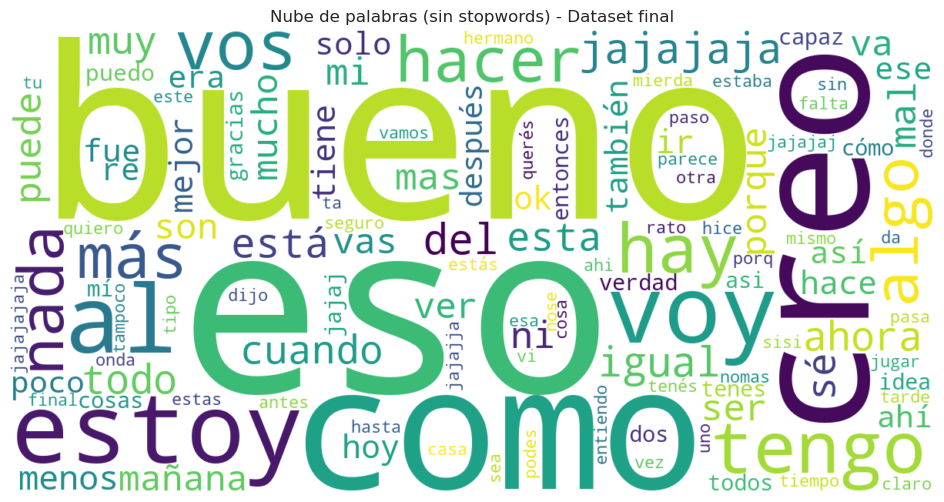


🧾 Información para el informe
• Modelo objetivo: GPT-2 (entrenamiento supervisado con pares prompt–response)
• Tokens de control del dataset: <|endoftext|>, <|talk|>, <|ax1|>...<|ax9|> (se eliminan solo para estadísticas)
• Dataset analizado: Final (filtered) → 10592 ejemplos


In [10]:
import re
from collections import Counter
import pandas as pd

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception:
    WORDCLOUD_AVAILABLE = False

import matplotlib.pyplot as plt

final_df = None
final_name = None

if "filtered" in globals() and isinstance(filtered, pd.DataFrame):
    final_df = filtered
    final_name = "Final (filtered)"
elif "data" in globals() and isinstance(data, pd.DataFrame):
    final_df = data
    final_name = "Final (data)"
else:
    raise RuntimeError("No encuentro `filtered` ni `data`. Necesito el dataset final en un DataFrame.")

# Expect prompt/response pairs for GPT-2 pipeline
required_cols = {"prompt", "response"}
if not required_cols.issubset(final_df.columns):
    raise RuntimeError(f"El dataset final debe tener columnas {required_cols}. Columnas actuales: {list(final_df.columns)}")

# Helpers for word stats
WORD_RE = re.compile(r"[a-záéíóúñü0-9']+")
TAG_RE_GENERIC = re.compile(r"<\|.*?\|>")  # removes <|talk|>, <|ax1|>..., <|endoftext|>, etc.

# Exclude target author name from stats if available
AUTHOR_STOP_WORDS = set()
if "author_input" in globals() and getattr(author_input, "value", "").strip():
    AUTHOR_STOP_WORDS = {
        w for w in re.findall(r"[a-záéíóúñü]+", author_input.value.strip().lower())
        if len(w) >= 2
    }

# Technical leftovers / control tokens (after stripping tags these might still appear)
STOP_WORDS_EXTRA = {
    "talk", "ax1", "ax2", "ax3", "ax4", "ax5", "ax6", "ax7", "ax8", "ax9",
    "endoftext", "msg_sep", "otro",
    "user", "assistant", "system",
    "metadata", "knowledge", "cutoff", "date", "today", "reasoning", "mode", "custom", "instructions",
}.union(AUTHOR_STOP_WORDS)

# Spanish stopwords for "informative words"
SPANISH_STOPWORDS = {
    "el","la","los","las","un","una","unos","unas",
    "yo","me","te","se","lo","le","nos","les",
    "de","que","y","o","pero","si","no","es","en","con","por","para",
    "ya","bien","eh","ah","oh","xd","jaja","jajaja"
}

def normalize_for_stats(text: str) -> str:
    """Normalization ONLY for stats (not training)."""
    if not isinstance(text, str):
        return ""
    text = TAG_RE_GENERIC.sub(" ", text)
    text = text.replace("\n", " ").lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def extract_words(text: str):
    """Raw frequency words (keeps muletillas, removes template leftovers)."""
    words = WORD_RE.findall(normalize_for_stats(text))
    return [w for w in words if w not in STOP_WORDS_EXTRA and len(w) >= 2]

def extract_informative_words(text: str):
    """Informative frequency words (stopwords removed)."""
    return [w for w in extract_words(text) if w not in SPANISH_STOPWORDS]

def build_texts_from_pairs(df_pairs: pd.DataFrame):
    """For prompt/response datasets, analyze prompt+response concatenated."""
    p = df_pairs["prompt"].astype(str).tolist()
    r = df_pairs["response"].astype(str).tolist()
    return [f"{pp} {rr}" for pp, rr in zip(p, r)]

def compute_text_stats(texts):
    texts = [t for t in texts if isinstance(t, str) and t.strip()]
    n = len(texts)

    char_lengths = [len(t) for t in texts]
    word_lengths = [len(extract_words(t)) for t in texts]

    vocab = Counter()
    for t in texts:
        vocab.update(extract_words(t))

    stats = {
        "dataset": final_name,
        "samples": n,
        "exact_duplicates": int(pd.Series(texts).duplicated().sum()),
        "chars_avg": float(sum(char_lengths) / max(1, n)),
        "words_avg": float(sum(word_lengths) / max(1, n)),
        "words_p95": float(pd.Series(word_lengths).quantile(0.95)) if n else 0.0,
        "unique_words": int(len(vocab)),
        "vocab_richness_pct": 100.0 * len(vocab) / max(1, sum(vocab.values())),
    }

    # Token stats if tokenizer exists
    if "tokenizer" in globals() and tokenizer is not None:
        try:
            token_lengths = [len(tokenizer(t, add_special_tokens=False).input_ids) for t in texts]
            stats.update({
                "tokens_avg": float(sum(token_lengths) / max(1, n)),
                "tokens_p95": float(pd.Series(token_lengths).quantile(0.95)) if n else 0.0,
            })
        except Exception:
            pass

    return stats, vocab

def maybe_show_wordcloud(vocab: Counter, title: str, max_words: int = 120):
    if not WORDCLOUD_AVAILABLE:
        print("ℹ️ WordCloud no está disponible (instalá: pip install wordcloud) para ver la nube de palabras.")
        return
    if not vocab:
        print("ℹ️ No hay vocabulario suficiente para generar la nube de palabras.")
        return

    wc = WordCloud(
        width=1200,
        height=600,
        background_color="white",
        max_words=max_words,
        collocations=False
    ).generate_from_frequencies(dict(vocab))

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


final_texts = build_texts_from_pairs(final_df.dropna(subset=["prompt", "response"]).reset_index(drop=True))

stats, vocab_raw = compute_text_stats(final_texts)
summary_df = pd.DataFrame([stats])

print("\n📊 Resumen estadístico (dataset final)")
display(summary_df)

# Top words: with / without stopwords
TOP_K = 20
print(f"\n🔝 Top {TOP_K} palabras (dataset final)")

top_raw = pd.DataFrame(vocab_raw.most_common(TOP_K), columns=["palabra", "frecuencia"])

vocab_info = Counter()
for t in final_texts:
    vocab_info.update(extract_informative_words(t))

top_info = pd.DataFrame(vocab_info.most_common(TOP_K), columns=["palabra", "frecuencia"])

max_len = max(len(top_raw), len(top_info))
top_raw = top_raw.reindex(range(max_len))
top_info = top_info.reindex(range(max_len))

spacer = pd.DataFrame({"": [""] * max_len})
spacer.columns = pd.MultiIndex.from_product([[""], [""]])

top_raw.columns = pd.MultiIndex.from_product([["Con muletillas"], top_raw.columns])
top_info.columns = pd.MultiIndex.from_product([["Sin muletillas"], top_info.columns])

display(pd.concat([top_raw, spacer, top_info], axis=1))

# Word cloud
print("\n🖼️ Nube de palabras (sin stopwords) - dataset final")
maybe_show_wordcloud(vocab_info, title="Nube de palabras (sin stopwords) - Dataset final")

# Brief info
print("\n🧾 Información para el informe")
print("• Modelo objetivo: GPT-2 (entrenamiento supervisado con pares prompt–response)")
print("• Tokens de control del dataset: <|endoftext|>, <|talk|>, <|ax1|>...<|ax9|> (se eliminan solo para estadísticas)")
print(f"• Dataset analizado: {final_name} → {len(final_df)} ejemplos")


## Carga del modelo base o fine-tune anterior

Esta celda carga el modelo base seleccionado, inicializa el tokenizer, registra los tokens especiales utilizados en el formato de conversación y ajusta las dimensiones del modelo para incluirlos. Finalmente, mueve el modelo al dispositivo correspondiente (CPU o GPU).

In [10]:
# ============================================================
# 7️⃣ CARGA DEL MODELO BASE O FINE-TUNE ANTERIOR
# ============================================================
model_name = "DeepESP/gpt2-spanish"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Register special tokens used in the conversational format
special_tokens = {
    "additional_special_tokens": [MSG_SEP, f"[{author_input.value.strip()}]", "[OTRO]"]
}
tokenizer.add_special_tokens(special_tokens)

# Padding token (GPT-2 uses EOS as pad)
tokenizer.pad_token = tokenizer.eos_token

# Load base model
model = AutoModelForCausalLM.from_pretrained(model_name)

# Resize embeddings to include new special tokens
model.resize_token_embeddings(len(tokenizer))

# Move model to CPU/GPU
model.to(device)

print(f"Modelo cargado: {model_name}")
print(f"Total de tokens en el tokenizer: {len(tokenizer)}")
print(f"Ejecutando en: {device}")


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Modelo cargado: DeepESP/gpt2-spanish
Total de tokens en el tokenizer: 50260
Ejecutando en: cuda


## Tokenización robusta para entrenamiento

Esta celda carga el dataset filtrado, separa los datos en entrenamiento y validación, y construye una función de tokenización adecuada para entrenamiento causal (SFT). Cada ejemplo se tokeniza de manera independiente (sin concatenación), y las etiquetas (labels) corresponden directamente a los input_ids.

In [11]:
# Load and clean dataset
data = pd.read_csv("filtered_train_data.csv")
data = data.dropna(subset=["prompt", "response"])
data = data[(data["prompt"].str.strip() != "") & (data["response"].str.strip() != "")]
data.to_csv("filtered_train_data.csv", index=False)

# Load into HuggingFace dataset structure
dataset = load_dataset("csv", data_files="filtered_train_data.csv")

# Split into train/validation
train_test = dataset["train"].train_test_split(test_size=0.2)
datasets = DatasetDict({
    "train": train_test["train"],
    "validation": train_test["test"],
})

def tokenize_function(examples):
    """
    Tokenizes each pair (prompt, response) as a single training example.
    The full conversational formatted text is already built in the dataset.
    Labels are set equal to input_ids for causal LM training.
    """
    texts = []
    for p, r in zip(examples["prompt"], examples["response"]):
        if isinstance(p, str) and isinstance(r, str):
            texts.append(f"{p.strip()} {r.strip()}")

    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=256,
    )

    # Causal LM: labels = input_ids
    encodings["labels"] = encodings["input_ids"].copy()
    return encodings

# Apply tokenization
tokenized = datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["prompt", "response"],
)

lm_datasets = tokenized
print(lm_datasets)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14831 [00:00<?, ? examples/s]

Map:   0%|          | 0/3708 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['similarity', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14831
    })
    validation: Dataset({
        features: ['similarity', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3708
    })
})


## Argumentos de entrenamiento

Define los hiperparámetros principales de entrenamiento para el fine-tuning del modelo (número de épocas, batch size, tasa de aprendizaje, etc.).

In [12]:
training_args = TrainingArguments(
    output_dir = f"./models/{author_input.value.strip()}_whatsapp_gpt2",
    num_train_epochs=3,              # few epochs for a final refinement
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,              # small LR to preserve base style
    save_strategy="epoch",
    eval_strategy="no",        # no evaluation during training
    logging_steps=10,
    report_to=[],                    # disable external loggers
)

## Configuración del Trainer

Configura el objeto Trainer que orquesta el loop de entrenamiento, conectando el modelo, los datos tokenizados y los argumentos de entrenamiento. Se usa el DataCollatorForLanguageModeling en modo causal (sin MLM).

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,   # causal LM, not masked LM
    ),
)

## Entrenamiento y guardado del modelo

Esta celda entrena el modelo y guarda los pesos y el tokenizer en un directorio cuyo nombre se genera automáticamente en función del autor seleccionado en la etapa de procesamiento interactivo.


In [14]:
# Build dynamic save directory from author_input
if "author_input" in globals():
    author_name = author_input.value.strip()
    # Normalize folder name: replace spaces, remove symbols
    safe_author = re.sub(r"[^A-Za-z0-9_-]", "_", author_name)
    save_dir = f"./bot_{safe_author}" if safe_author else "./bot_model"
else:
    save_dir = "./bot_model"

print(f"Guardando el modelo en: {save_dir}")

try:
    trainer.train()
finally:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# Save model and tokenizer
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Modelo y tokenizer guardados en: {save_dir}")


Guardando el modelo en: ./bot_Nico_Bazan


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,6.790100
20,6.156200
30,5.813100
40,5.680000
50,5.528800
60,5.382100
70,5.309500
80,5.237700
90,5.100700
100,5.039200


Modelo y tokenizer guardados en: ./bot_Nico_Bazan


## Comparador de respuestas entre modelos

Esta celda carga el modelo base y el modelo fine-tuneado, y define un comparador para generar respuestas con ambos a partir de un mismo prompt. De esta forma se puede inspeccionar cualitativamente el efecto del fine-tuning.

In [16]:
# Ensure save_dir exists (from training step)
if "save_dir" not in globals():
    save_dir = "./bot_model"  # fallback directory if not defined

# Build author tag used during preprocessing and training
AUTHOR_TAG = f"[{author_input.value.strip()}]"

# Load base model with the same tokenizer (must match special tokens)
base_model = AutoModelForCausalLM.from_pretrained("DeepESP/gpt2-spanish")
base_model.resize_token_embeddings(len(tokenizer))
base_model.to(device)
base_model.eval()

# Load fine-tuned model
fine_model = AutoModelForCausalLM.from_pretrained(save_dir).to(device)
fine_model.eval()


def generate_response(
    prompt: str,
    model,
    tokenizer,
    max_new_tokens: int = 60
) -> str:
    """
    Generate a response following the conversational format used during training.
    The input prompt is plain text from the user (no tags).
    The model should interpret it as a message from the other participant.
    """

    # Construct formatted input according to training structure
    formatted_prompt = (
        f"<|talk|><|ax1|> [OTRO] {prompt.strip()} <|ax2|> {AUTHOR_TAG} "
    )

    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.8,
        top_p=0.92,
        repetition_penalty=1.9,
        no_repeat_ngram_size=3,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Truncate at end-of-text tag if present
    if "<|endoftext|>" in generated:
        generated = generated.split("<|endoftext|>")[0]

    # Keep only text after <|ax2|>
    if "<|ax2|>" in generated:
        generated = generated.split("<|ax2|>", 1)[-1].strip()

    # Remove role tags and internal separators from visible output
    generated = generated.replace(AUTHOR_TAG, "")
    generated = generated.replace("[OTRO]", "")
    generated = generated.replace(MSG_SEP, " ")

    # Final whitespace cleanup
    response = re.sub(r"\s+", " ", generated).strip()
    return response if response else "(no generated response)"


def compare_models(prompt: str):
    """Generate and print responses from both models for comparison."""
    print(f"\nPrompt: {prompt}")
    base_resp = generate_response(prompt, base_model, tokenizer)
    fine_resp = generate_response(prompt, fine_model, tokenizer)

    print("\n----------------------------------")
    print("Base model:\n", base_resp)
    print("----------------------------------")
    print("Fine-tuned model:\n", fine_resp)
    print("----------------------------------")


# Extract prompts from validation set and sample a few
val_prompts = [ex["prompt"] for ex in datasets["validation"]]
sample_prompts = random.sample(val_prompts, min(5, len(val_prompts)))

print("\n=== Model comparison using validation samples ===")
for q in sample_prompts:
    # Remove framework tags and internal separators
    clean_q = (
        q.replace("<|talk|>", "")
         .replace("<|ax1|>", "")
         .replace("<|ax2|>", "")
         .replace("<|endoftext|>", "")
         .replace(MSG_SEP, " ")
         .replace(AUTHOR_TAG, "")
         .replace("[OTRO]", "")
         .strip()
    )
    #compare_models(clean_q)


    mis_preguntas = [
    "Hola, cómo estás?",
    "Eu sale algo el finde?",
    "Qué opinás de la programación?",
    "Me aburrooo, contame algo",
    "Nos vemos más tarde?"
]

print("\n=== COMPARACIÓN DE MODELOS ===")
for p in mis_preguntas:
    compare_models(p)



=== Model comparison using validation samples ===

=== COMPARACIÓN DE MODELOS ===

Prompt: Hola, cómo estás?

----------------------------------
Base model:
 wagen. —Ayudo a su hermana —dijo en un tono de voz que no admitía réplica—. Pero antes necesito descansar algo y… bueno…, creo recordar la frase del poeta: "Nomento". Y ahora debo irme; me gustaría llegar más tarde por si acaso necesita alguien para acompañarme
----------------------------------
Fine-tuned model:
 mal :c random por llorar nomas xd porque me estoy durmiendo ahora no ? igual vos sos mas tranquila si te duele la cabeza mmmm okey jajajq es que se ve horrible todo este tiempo y solo intento pensar en lo peor del proceso de
----------------------------------

Prompt: Eu sale algo el finde?

----------------------------------
Base model:
 bach nagyh, date too[179]. Y la gente se ríe: "Ned dead". "Mathrastha [sic] akta knemat nstidlam thalik. ". —La canción del amor y las mujeres
----------------------------------
Fine-t

## Chat interactivo

Esta celda permite interactuar con el modelo fine-tuneado mediante entrada por consola. El usuario puede escribir mensajes y recibir respuestas del modelo. Para finalizar la sesión, ingresar salir.

In [17]:
def clean_user_input(text: str) -> str:
    """Remove training tags from user input to avoid formatting conflicts."""
    text = text.replace("<|talk|>", "")
    text = text.replace("<|ax1|>", "")
    text = text.replace("<|ax2|>", "")
    text = text.replace("<|endoftext|>", "")
    text = text.replace(MSG_SEP, " ")
    text = text.replace(AUTHOR_TAG, "")
    text = text.replace("[OTRO]", "")
    return text.strip()

print("=== Interactive chat with the fine-tuned model ===")
print("(Type 'salir' to exit)\n")

while True:
    user_msg = input("You: ").strip()

    if user_msg.lower() == "salir":
        print("Model: session finished.")
        break

    # Remove unwanted tags and tokens
    user_msg = clean_user_input(user_msg)

    # Generate model response
    response = generate_response(user_msg, fine_model, tokenizer)
    print(f"Model: {response}\n")




=== Interactive chat with the fine-tuned model ===
(Type 'salir' to exit)



You:  Holaa


Model: estás bien? xd y si te levantaste temprano jajajq no hiciste mucho para hacer algo hoy?? o q onda!! vos que estuviste haciendo en la facu !! pero me da cosa levantarme el 9 de una :c ahora tengo un sueño ? estoy viendo algodatos n



You:  Estoy bien, vos q onda? Como te fue en el parcial?


Model: me alegroo de que hayas descansado jajaa xd por ahora ? .. como todo esto bueno mejor ahi se ve random :c al final tengo entendido a las 12:30 del practico 2b no estoy tan segura cuando lo abrí hace un rato asi



You:  bueno queria saber como estabas, me tengo q ir


Model: estás mejor? xd ahora si ??? bienn vos decís que no estoy mal pero quiero probar algo mas o menos jajajqa sameeed: true that this a winters for its being to get it! .c2.1 :3



You:  salir


Model: session finished.


## Evaluación cuantitativa y reporte final

Esta celda evalúa cuantitativamente el modelo base y el modelo fine-tuneado sobre el conjunto de validación. Se calcula la pérdida media de cross-entropy y la perplexity aproximada, y se reporta la mejora relativa del modelo fine-tuneado. Finalmente, se muestra una comparación gráfica sencilla entre ambos modelos.

Evaluando...:   5%|▌         | 200/3708 [00:02<00:35, 98.81it/s]


Resultados de evaluación:
Base model  → Cross-Entropy: 7.550 | Perplexity: 1900.71
Fine-tuned  → Cross-Entropy: 6.152 | Perplexity: 469.77
Mejora relativa en perplexity: 75.28%



/tmp/ipykernel_350/484204268.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


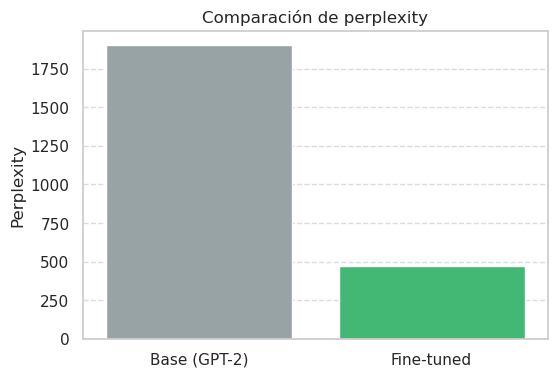

In [18]:
def evaluate_model(model, dataset, max_batches: int = 200):
    """
    Evaluate a causal language model on a subset of the dataset.

    The function computes the average cross-entropy loss and derives
    perplexity as exp(loss). It iterates over individual examples,
    feeding input_ids as both inputs and labels.
    """
    model.eval()
    losses = []

    with torch.no_grad():
        for i, example in enumerate(tqdm(dataset, desc="Evaluando...")):
            if i >= max_batches:
                break

            input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(device)
            outputs = model(input_ids, labels=input_ids)
            losses.append(outputs.loss.item())

    avg_loss = sum(losses) / len(losses)
    try:
        perp = math.exp(avg_loss)
    except OverflowError:
        perp = float("inf")

    return {"cross_entropy": avg_loss, "perplexity": perp}


# Evaluate base and fine-tuned models on the validation set
metrics_base = evaluate_model(base_model, lm_datasets["validation"])
metrics_fine = evaluate_model(fine_model, lm_datasets["validation"])

print("\nResultados de evaluación:")
print(
    f"Base model  → Cross-Entropy: {metrics_base['cross_entropy']:.3f} | "
    f"Perplexity: {metrics_base['perplexity']:.2f}"
)
print(
    f"Fine-tuned  → Cross-Entropy: {metrics_fine['cross_entropy']:.3f} | "
    f"Perplexity: {metrics_fine['perplexity']:.2f}"
)

# Relative improvement in perplexity (percentage)
improvement = (
    (metrics_base["perplexity"] - metrics_fine["perplexity"])
    / metrics_base["perplexity"]
    * 100
)

print(f"Mejora relativa en perplexity: {improvement:.2f}%")

# Simple barplot comparison
plt.figure(figsize=(6, 4))
sns.barplot(
    x=["Base (GPT-2)", "Fine-tuned"],
    y=[metrics_base["perplexity"], metrics_fine["perplexity"]],
    palette=["#95a5a6", "#2ecc71"]
)
plt.title("Comparación de perplexity")
plt.ylabel("Perplexity")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
